Epoch: 0 | Train Loss: 0.865564 | Test Loss: 0.419238 | Test Accuracy: -49.94%


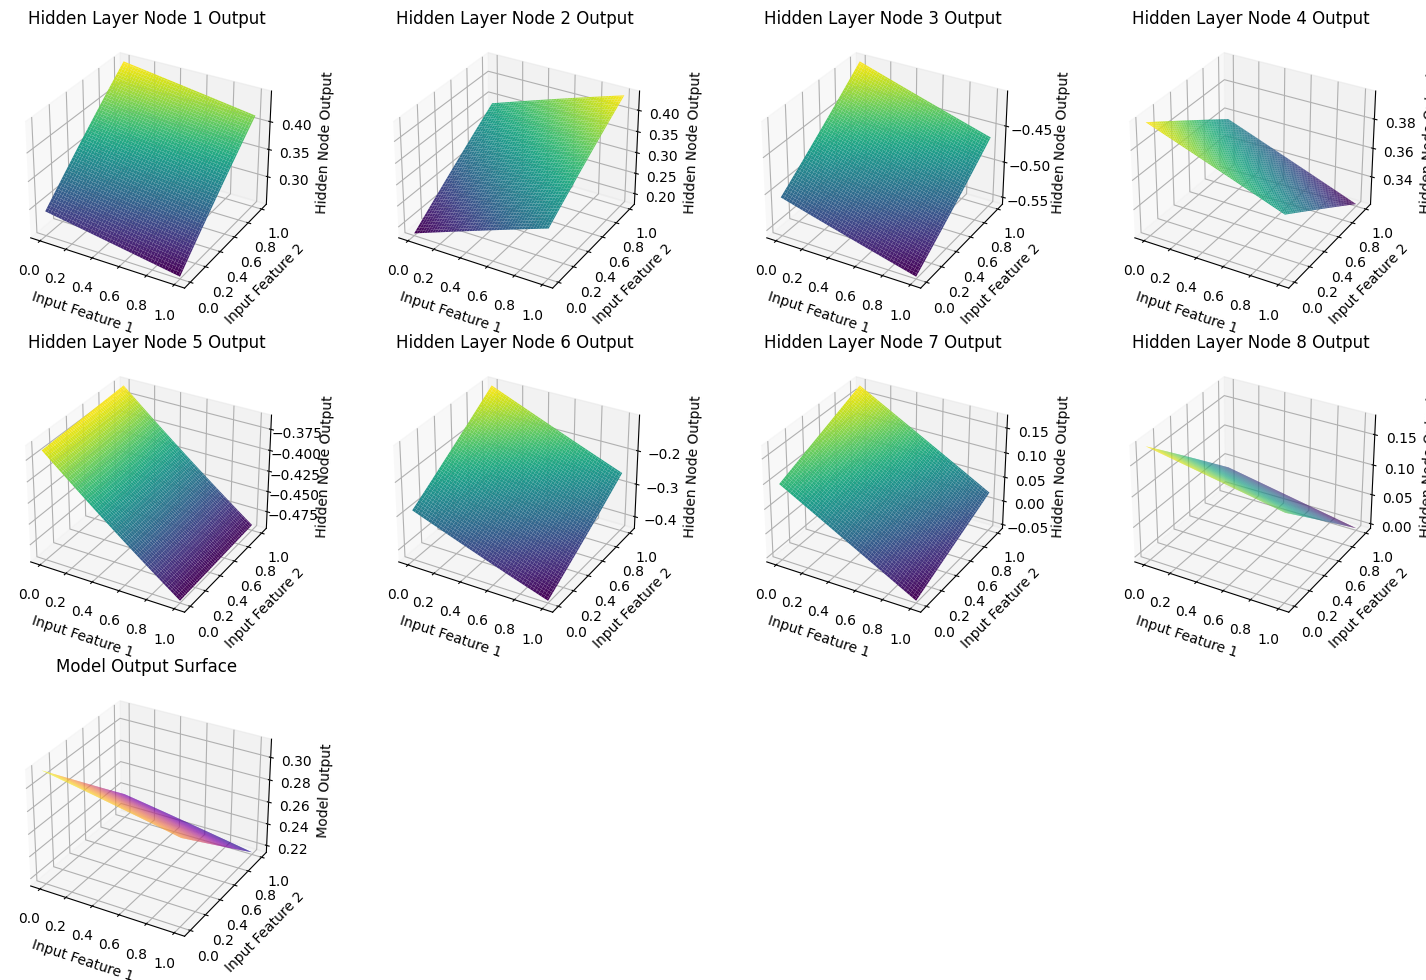

Epoch: 10 | Train Loss: 0.186686 | Test Loss: 0.246878 | Test Accuracy: 11.71%


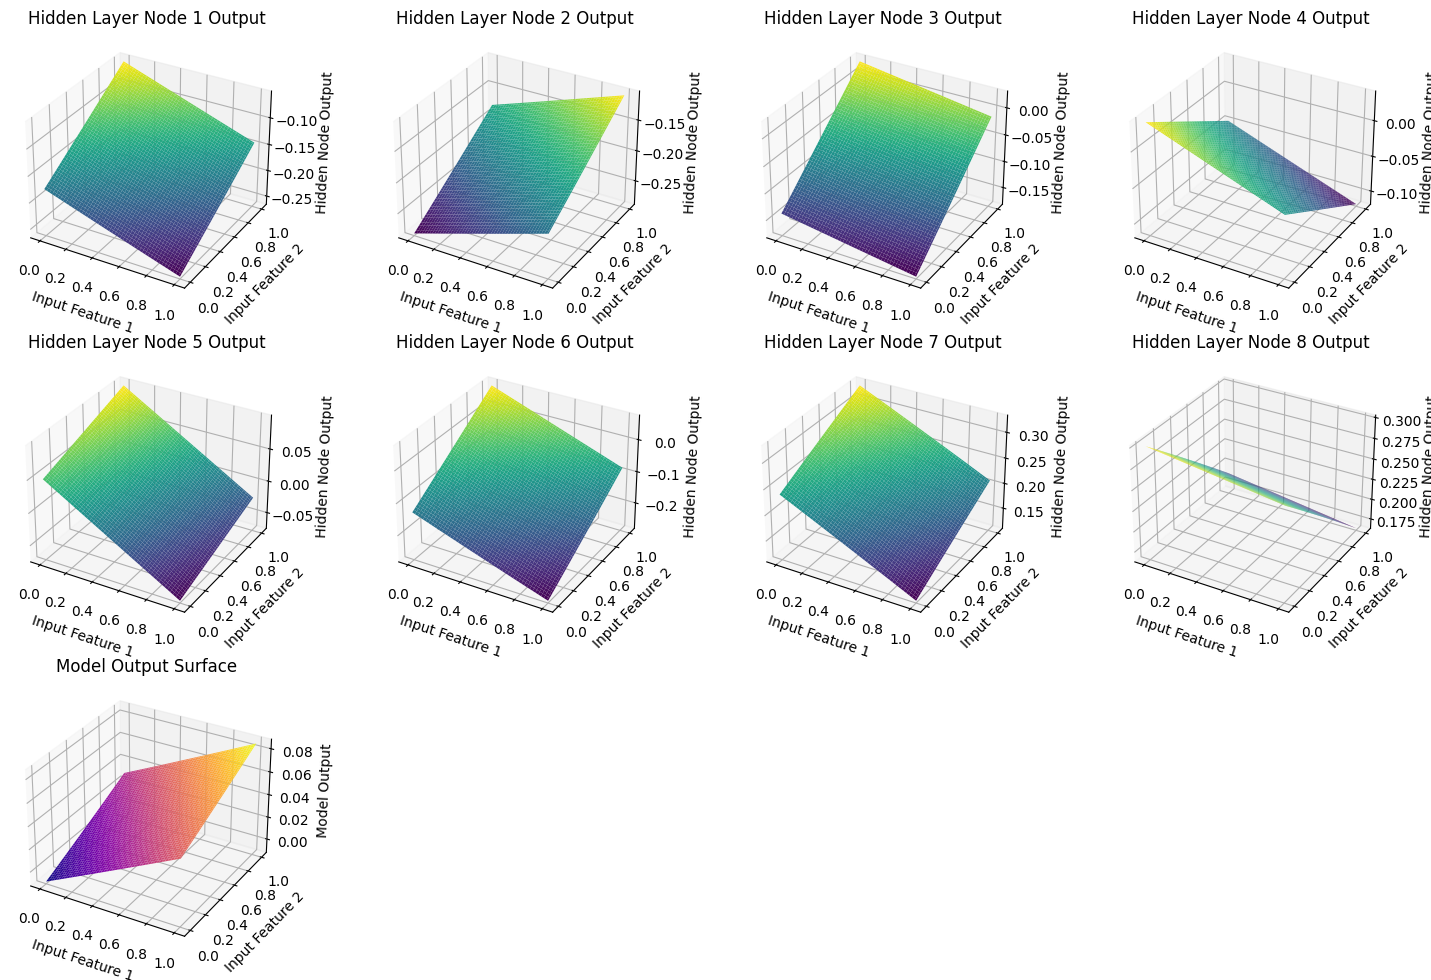

Epoch: 20 | Train Loss: 0.049056 | Test Loss: 0.098903 | Test Accuracy: 64.63%
Epoch: 30 | Train Loss: 0.053400 | Test Loss: 0.113559 | Test Accuracy: 59.39%
Epoch: 40 | Train Loss: 0.026521 | Test Loss: 0.075900 | Test Accuracy: 72.85%
Epoch: 50 | Train Loss: 0.028106 | Test Loss: 0.072230 | Test Accuracy: 74.17%


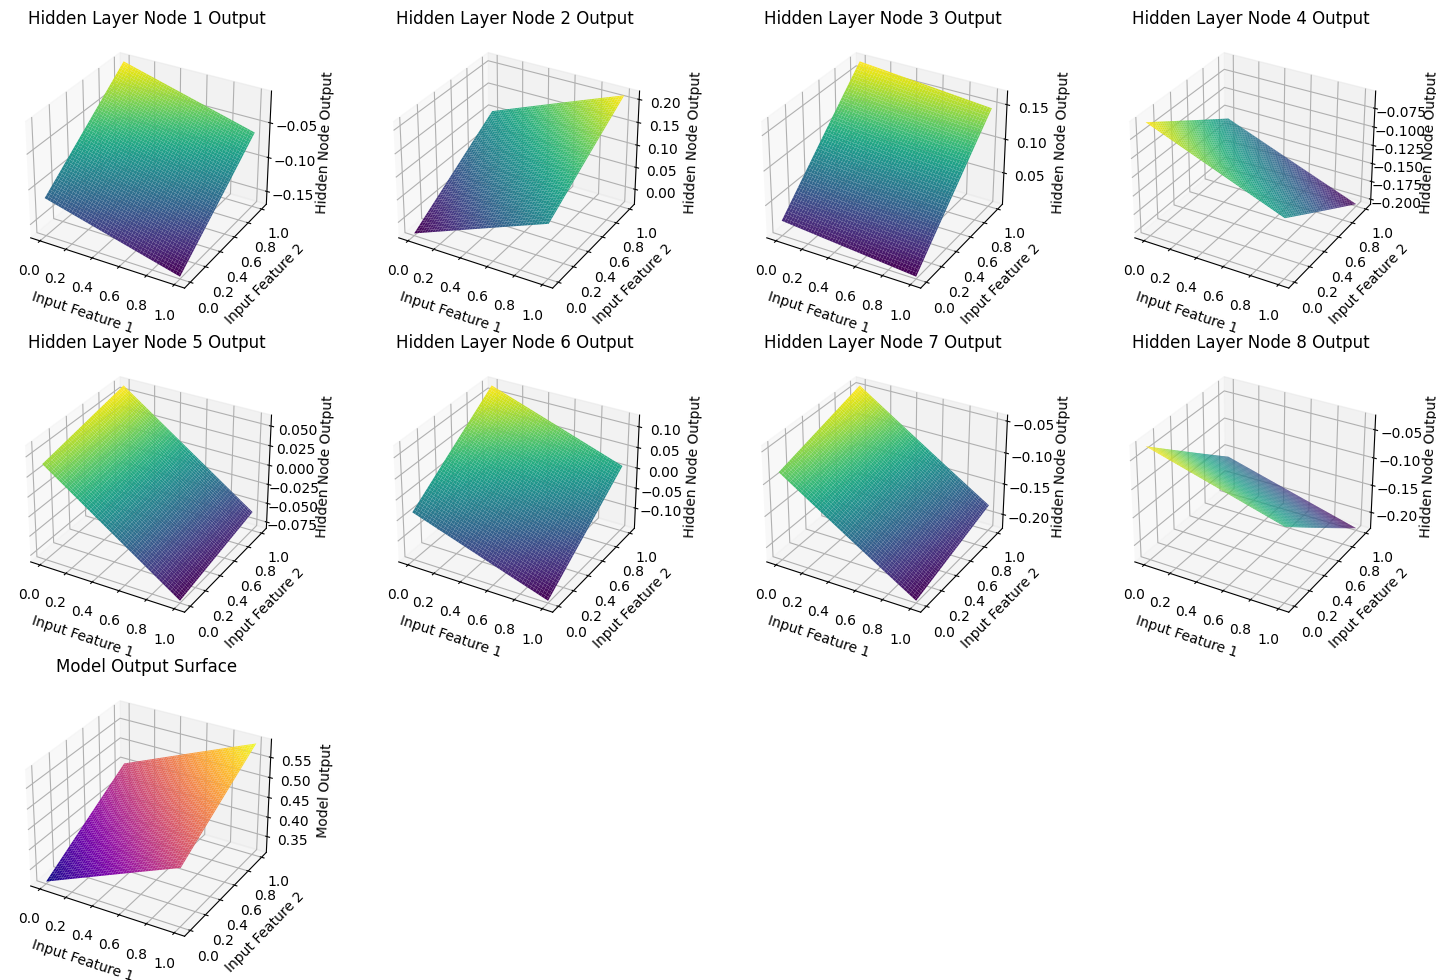

Epoch: 60 | Train Loss: 0.025051 | Test Loss: 0.069697 | Test Accuracy: 75.07%
Epoch: 70 | Train Loss: 0.023986 | Test Loss: 0.066946 | Test Accuracy: 76.06%
Epoch: 80 | Train Loss: 0.024046 | Test Loss: 0.066182 | Test Accuracy: 76.33%
Stopping early at epoch 82, loss change 0.000001 < 1e-05


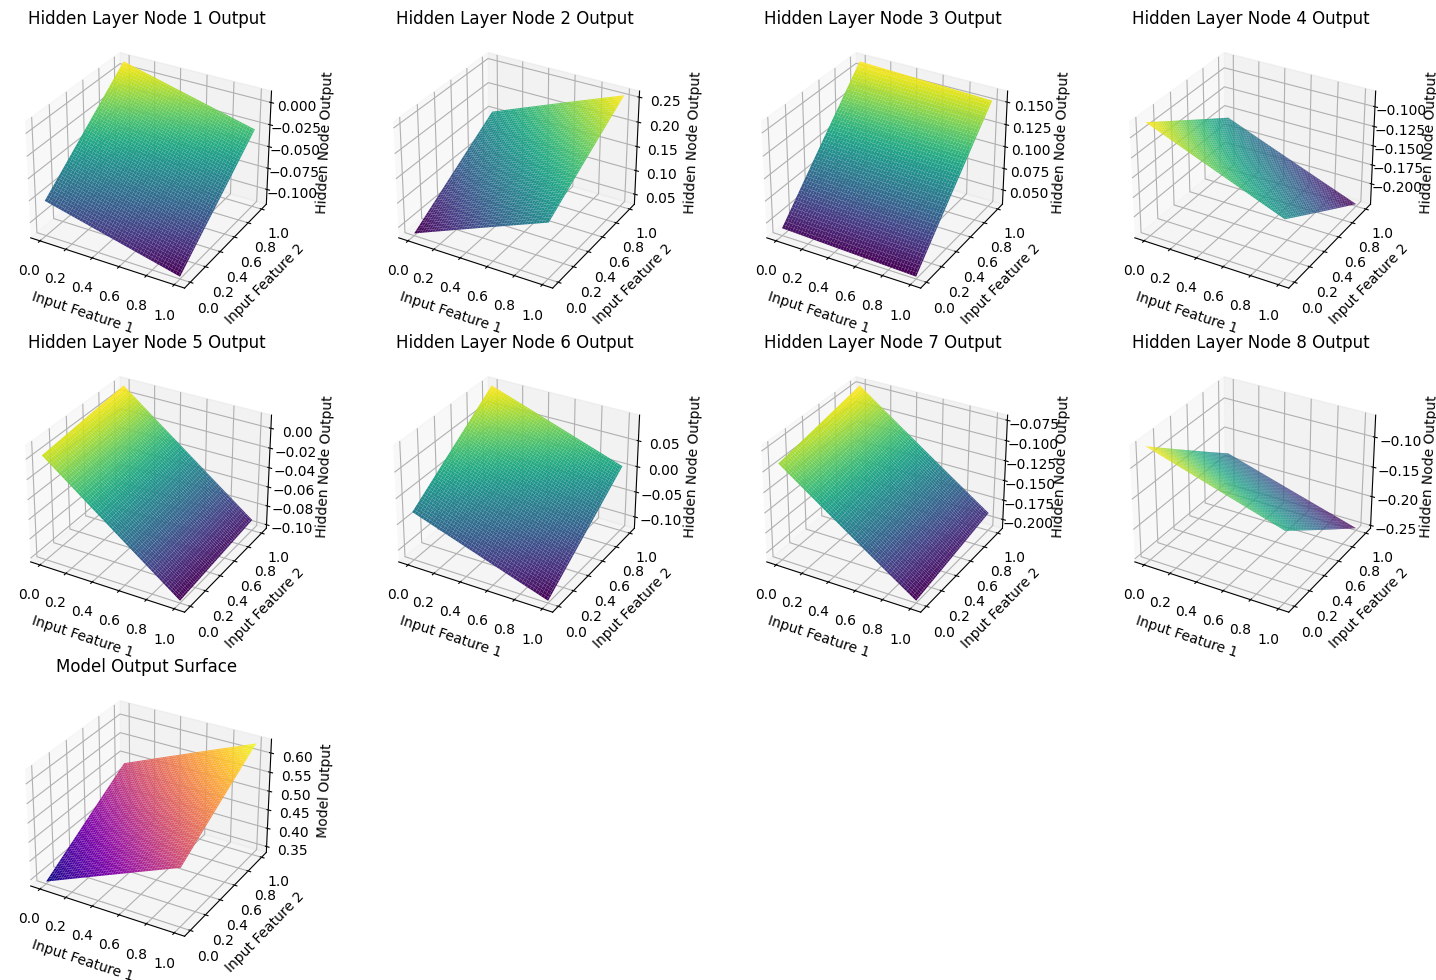

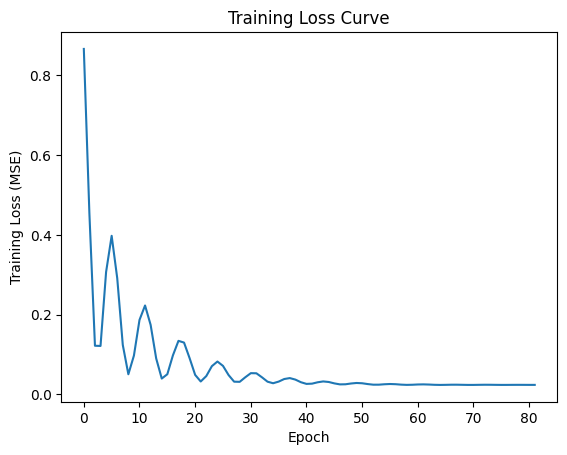

Test Loss: 0.066793 | Test Accuracy: 76.11%


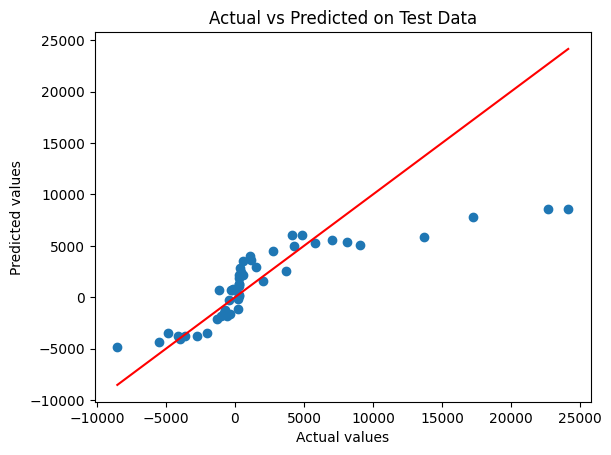

Train Loss: 0.024126 | Train Accuracy: 90.87%


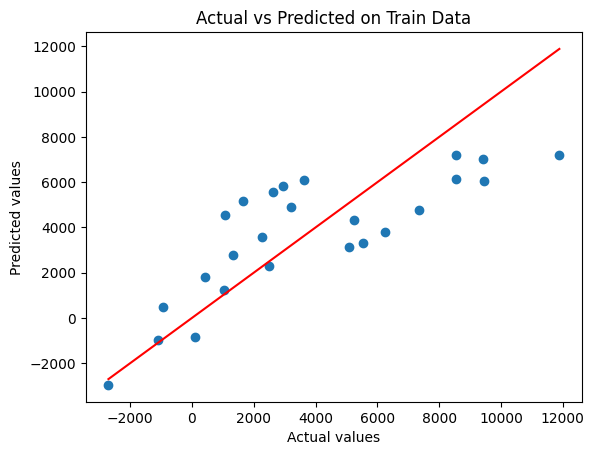

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define normalization scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Load and normalize the data
train = pd.read_csv('Dataset-1/Train-2a-25.csv')
test = pd.read_csv('Dataset-1/Test-50.csv')
val = pd.read_csv('Dataset-1/Val-50.csv')

# Separate input features and output values
X_train = train.iloc[:, :-1].to_numpy()
y_train = train.iloc[:, -1].to_numpy().reshape(-1, 1)

X_test = test.iloc[:, :-1].to_numpy()
y_test = test.iloc[:, -1].to_numpy().reshape(-1, 1)

X_val = val.iloc[:, :-1].to_numpy()
y_val = val.iloc[:, -1].to_numpy().reshape(-1, 1)

# Normalize features and outputs
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
X_val = scaler_X.transform(X_val)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)
y_val = scaler_y.transform(y_val)

# Convert numpy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).to(device)

X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).to(device)

X_val = torch.from_numpy(X_val).type(torch.float32).to(device)
y_val = torch.from_numpy(y_val).type(torch.float32).to(device)

def show_surface_plots(model, scaler_X, scaler_y):
    # Create a mesh grid for input data
    x1_range = np.linspace(0, 1, 100)  # Assuming inputs are normalized between 0 and 1
    x2_range = np.linspace(0, 1, 100)
    X1_mesh, X2_mesh = np.meshgrid(x1_range, x2_range)

    # Prepare input tensor for the model
    input_data = np.c_[X1_mesh.ravel(), X2_mesh.ravel()]
    input_tensor = torch.from_numpy(scaler_X.transform(input_data)).float().to(device)

    # Get model predictions for the grid
    with torch.no_grad():
        hidden_output, output_logits = model(input_tensor)

    # Reshape outputs for plotting
    output_mesh = output_logits.cpu().numpy().reshape(X1_mesh.shape)
    hidden_mesh = hidden_output.cpu().numpy().reshape(X1_mesh.shape[0], X1_mesh.shape[1], 8)  # Reshape hidden layer output

    # Create surface plot for hidden layers and output
    fig = plt.figure(figsize=(15, 10))  # Increased figure size for more space

    # Plot hidden layer activations
    for i in range(8):
        ax = fig.add_subplot(3, 4, i + 1, projection='3d')  # 3x4 grid, leaving space for output plot
        ax.plot_surface(X1_mesh, X2_mesh, hidden_mesh[:, :, i], cmap='viridis', edgecolor='none')
        ax.set_title(f'Hidden Layer Node {i + 1} Output')
        ax.set_xlabel('Input Feature 1')
        ax.set_ylabel('Input Feature 2')
        ax.set_zlabel('Hidden Node Output')

    # Plot output layer surface in a separate subplot
    ax = fig.add_subplot(3, 4, 9, projection='3d')  # 9th plot reserved for output layer
    ax.plot_surface(X1_mesh, X2_mesh, output_mesh, cmap='plasma', edgecolor='none')
    ax.set_title('Model Output Surface')
    ax.set_xlabel('Input Feature 1')
    ax.set_ylabel('Input Feature 2')
    ax.set_zlabel('Model Output')

    # Adjust layout to avoid overlaps
    plt.tight_layout(pad=2.0)  # Added more padding between plots for better spacing
    plt.show()

# Define the neural network with one hidden layer of 8 nodes
class FunctionApproximationModel(nn.Module):
    def __init__(self):
        super(FunctionApproximationModel, self).__init__()
        self.hidden_layer = nn.Linear(2, 8)  # One hidden layer with 8 nodes
        self.output_layer = nn.Linear(8, 1)  # Output layer for regression (1 output)

    def forward(self, x):
        h = torch.tanh(self.hidden_layer(x))  # Use tanh activation for hidden layer
        return h, self.output_layer(h)  # Return hidden layer output and final output

# Instantiate the model, define loss and optimizer
model = FunctionApproximationModel().to(device)
loss_fn = nn.MSELoss()  # MSE loss for function approximation
optimizer = torch.optim.SGD(model.parameters(), lr=0.07, momentum=0.9, weight_decay=0.01)  # Added weight decay for regularization

# Training loop
num_epochs = 200
train_errors = []
prev_loss = float('inf')
threshold = 0.00001  # Early stopping threshold

for epoch in range(num_epochs):
    model.train()

    # Forward pass
    hidden_output, predictions = model(X_train)
    loss = loss_fn(predictions, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track training error
    train_errors.append(loss.item())

    # Early stopping condition
    loss_change = abs(prev_loss - loss.item())
    prev_loss = loss.item()

    if loss_change < threshold:
        print(f"Stopping early at epoch {epoch + 1}, loss change {loss_change:.6f} < {threshold}")
        show_surface_plots(model, scaler_X, scaler_y)  # Plot after convergence
        break

    # Print loss and accuracy every 10 epochs
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_hidden_output, test_predictions = model(X_test)
            test_loss = loss_fn(test_predictions, y_test)

        # Calculate accuracy
        test_accuracy = (1 - test_loss.item() / np.mean(y_test.cpu().numpy()**2)) * 100  # Example accuracy metric

        print(f"Epoch: {epoch} | Train Loss: {loss.item():.6f} | Test Loss: {test_loss.item():.6f} | Test Accuracy: {test_accuracy:.2f}%")

    # Generate surface plots at epochs 1, 10, 50, and after convergence
    if epoch in [1, 10, 50]:
        show_surface_plots(model, scaler_X, scaler_y)

# Plot the training loss curve
plt.plot(range(len(train_errors)), train_errors)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (MSE)")
plt.title("Training Loss Curve")
plt.show()


# Test the model
model.eval()
with torch.no_grad():
    test_hidden_output, predictions = model(X_test)
    test_loss = loss_fn(predictions, y_test)
    test_accuracy = (1 - test_loss.item() / np.mean(y_test.cpu().numpy()**2)) * 100  # Example accuracy metric
    print(f"Test Loss: {test_loss.item():.6f} | Test Accuracy: {test_accuracy:.2f}%")

# Denormalize and visualize the prediction vs actual
predicted = scaler_y.inverse_transform(predictions.cpu().numpy())
actual = scaler_y.inverse_transform(y_test.cpu().numpy())

plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red')  # Reference line
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted on Test Data')
plt.show()

# Test the model
model.eval()
with torch.no_grad():
    train_hidden_output, predictions = model(X_train)
    train_loss = loss_fn(predictions, y_train)
    train_accuracy = (1 - train_loss.item() / np.mean(y_train.cpu().numpy()**2)) * 100  # Example accuracy metric
    print(f"Train Loss: {train_loss.item():.6f} | Train Accuracy: {train_accuracy:.2f}%")

# Denormalize and visualize the prediction vs actual
predicted = scaler_y.inverse_transform(predictions.cpu().numpy())
actual = scaler_y.inverse_transform(y_train.cpu().numpy())

plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red')  # Reference line
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted on Train Data')
plt.show()
